### Import necessary libraryies :

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from sklearn.cluster import KMeans

# Elbow method for KMeans clustering analysis
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# module to convert an address into latitude and longitude values
!pip install geopy
from geopy.geocoders import Nominatim 

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# plotting library
! pip install folium==0.5.0
import folium 

### Foursqure setting :

In [2]:
CLIENT_ID = 'FGF1SK2HYOHKUIPSVAKXSEPTVYRRS3FMS4OE4WTWKDDYSHTE' # your Foursquare ID
CLIENT_SECRET = '1FDO4E41CFGZBFYRKGE1TOXR2NM5DD0MIFNCC2GY5RHH5SS4' # your Foursquare Secret
ACCESS_TOKEN = 'UYPUGMAYB2TFJACUJN3BAM5ERGZZUHW3B1NQTH0LL12K2RN2' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

def json_parser(url):
    results = requests.get(url).json()
    # assign relevant part of JSON to venues
    venues = results['response']['venues']

    # tranform venues into a dataframe
    dataframe = json_normalize(venues)
    
    dataframe = dataframe[['name', 'location.lat', 'location.lng']]
    dataframe.columns = ['name', 'lat', 'lng']
    
    return dataframe

Your credentails:
CLIENT_ID: FGF1SK2HYOHKUIPSVAKXSEPTVYRRS3FMS4OE4WTWKDDYSHTE
CLIENT_SECRET:1FDO4E41CFGZBFYRKGE1TOXR2NM5DD0MIFNCC2GY5RHH5SS4


### Show the dataframe including 12 Taipei Districts :

In [3]:
Taipei_districts_name = ["Wanhua district taipei", "Datong district taipei", "Zhongzheng district taipei", 
                         "Daan district taipei", "Xinyi district taipei", "Zhongshan district taipei",
                         "Songshan district taipei", "Beitou district taipei", "Shilin district taipei",
                         "Neihu district taipei", "Nangang district taipei", "Wenshan district taipei"]

# Create a dataframe to collect cooridinates of the center of the 12 districts
Taipei_district_df = pd.DataFrame(columns=["District", "lat", "lng"])

for district in Taipei_districts_name :
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(district)
    latitude = location.latitude
    longitude = location.longitude
    District_name = district.split()[0]
    #print(District_name, latitude, longitude)
    
    df2 = {'District' : District_name, 'lat' : latitude, 'lng': longitude}
    
    Taipei_district_df = Taipei_district_df.append(df2, ignore_index=True)
    
# Show the result :
Taipei_district_df

,District,lat,lng
0,Wanhua,25.031933,121.499332
1,Datong,25.065986,121.515514
2,Zhongzheng,25.032361,121.518267
3,Daan,25.026515,121.534395
4,Xinyi,25.033345,121.566896
5,Zhongshan,25.064361,121.533468
6,Songshan,25.049885,121.577272
7,Beitou,25.131931,121.498593
8,Shilin,25.091840,121.524207
9,Neihu,25.069664,121.588998


### The current distribution of bubble tea shops in 12 Taipei districts :

Text(0.5, 1.0, 'Bubble tea shops distribution over 12 districts')

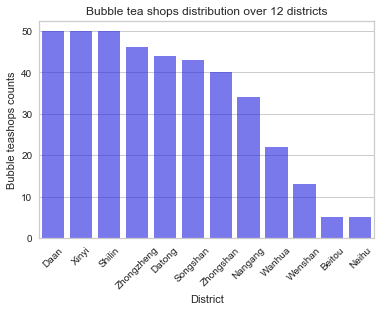

In [4]:
BubbleTeaShop_ID= '52e81612bcbc57f1066b7a0c'

radius = 1000

BubbleTeaShop_url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, BubbleTeaShop_ID, radius, LIMIT)

BubbleTeaShop_df = json_parser(BubbleTeaShop_url)
BubbleTeaShop_df.shape[0]

bubble_count=[]

for district, lat, lng in zip(Taipei_district_df['District'], Taipei_district_df['lat'], Taipei_district_df['lng']):
    
    url= 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, ACCESS_TOKEN, VERSION, BubbleTeaShop_ID, radius, LIMIT)
    #url= 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, ACCESS_TOKEN, VERSION, BubbleTeaShop_ID, radius, LIMIT)
    #print(district, lat, lng)
    
    parser_result_df = json_parser(url)
    bubble_tea_shop_count = parser_result_df.shape[0]
    
    #Taipei_district_df.loc[i, ['Bubble_tea_amount']]=bubble_tea_shop_count
    
    bubble_count.append(bubble_tea_shop_count)

Taipei_district_df['bubble_teashop_counts'] = bubble_count

import seaborn as sns
import matplotlib.pyplot as plt

pd_df = Taipei_district_df.sort_values(['bubble_teashop_counts'], ascending=False).reset_index(drop=True)


sns.barplot(x = 'District', y = 'bubble_teashop_counts', color ='blue', alpha=0.6, data = pd_df)

plt.ylabel("Bubble teashops counts")
plt.xticks(rotation=45)
plt.title("Bubble tea shops distribution over 12 districts")


### 5 selected features might be the factor attracting people come to buy bubble tea.

* College
* School
* Bus stop
* Metro station
* Hotel

In [5]:
# Create 5 empty columns for these features

Taipei_district_df['College_counts'] = ""
Taipei_district_df['School_counts']  = ""
Taipei_district_df['Bus_stop_counts']= ""
Taipei_district_df['Hotel_counts']   = ""
Taipei_district_df['Metro_counts']   = ""

# Derive the categories ID from Foursqure API website
College_ID = '4d4b7105d754a06372d81259'
School_ID  = '4bf58dd8d48988d13b941735'
Bus_stop_ID= '52f2ab2ebcbc57f1066b8b4f'
Hotel_ID   = '4bf58dd8d48988d1fa931735'
Metro_ID  = '4bf58dd8d48988d1fd931735'

feature_list=[College_ID, School_ID, Bus_stop_ID, Hotel_ID, Metro_ID]
#feature_list=[College_ID, School_ID]

j = 4

for feature in feature_list:
    i = 0
    for district, lat, lng in zip(Taipei_district_df['District'], Taipei_district_df['lat'], Taipei_district_df['lng']):
    
        url= 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, ACCESS_TOKEN, VERSION, feature, radius, LIMIT)

        #print(district, lat, lng)

        parser_result_df = json_parser(url)
        feature_count = parser_result_df.shape[0]

        Taipei_district_df.iloc[i, j]= feature_count

        i+=1
        
    j+=1
    
        #bubble_count.append(bubble_tea_shop_count)

In [6]:
Taipei_district_df

,District,lat,lng,bubble_teashop_counts,College_counts,School_counts,Bus_stop_counts,Hotel_counts,Metro_counts
0,Wanhua,25.031933,121.499332,22,6,29,28,28,3
1,Datong,25.065986,121.515514,44,27,28,26,47,3
2,Zhongzheng,25.032361,121.518267,46,46,44,36,26,5
3,Daan,25.026515,121.534395,50,49,49,31,50,7
4,Xinyi,25.033345,121.566896,50,40,38,24,46,5
5,Zhongshan,25.064361,121.533468,40,17,18,24,47,3
6,Songshan,25.049885,121.577272,43,11,29,33,30,4
7,Beitou,25.131931,121.498593,5,7,9,7,24,4
8,Shilin,25.091840,121.524207,50,48,21,22,31,2
9,Neihu,25.069664,121.588998,5,5,12,6,2,1


### Clustering analysis with the features may attract people to buy bubble tea :

I use the elbow method to descide the number of clusters.

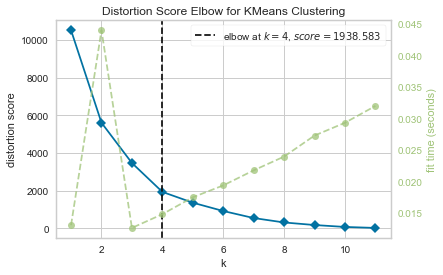

In [7]:
District_feature_clustering = Taipei_district_df.drop(['bubble_teashop_counts', 'District', 'lat', 'lng'], axis = 1)
District_feature_clustering

model_feature = KMeans()
visualizer = KElbowVisualizer(model_feature, k=(1,12))

visualizer.fit(District_feature_clustering)
visualizer.show()

In [8]:
District_feature_clustering

,College_counts,School_counts,Bus_stop_counts,Hotel_counts,Metro_counts
0,6,29,28,28,3
1,27,28,26,47,3
2,46,44,36,26,5
3,49,49,31,50,7
4,40,38,24,46,5
5,17,18,24,47,3
6,11,29,33,30,4
7,7,9,7,24,4
8,48,21,22,31,2
9,5,12,6,2,1


The number of clusters is 4 and I use Kmeans clustering method to carry on the analysis : 

In [9]:
# set number of clusters
kclusters_bubbletea = 4

# run k-means clustering with number of cluster decided by elbow method
kmeans_bubbletea = KMeans(n_clusters=kclusters_bubbletea, random_state=0).fit(District_feature_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_bubbletea.labels_

#Taipei_district_df.drop(['Clusterlabel'], axis = 1, inplace=True)

Taipei_district_df.insert(0, 'Clusterlabel', kmeans_bubbletea.labels_)

Taipei_district_df

,Clusterlabel,District,lat,lng,bubble_teashop_counts,College_counts,School_counts,Bus_stop_counts,Hotel_counts,Metro_counts
0,2,Wanhua,25.031933,121.499332,22,6,29,28,28,3
1,2,Datong,25.065986,121.515514,44,27,28,26,47,3
2,3,Zhongzheng,25.032361,121.518267,46,46,44,36,26,5
3,3,Daan,25.026515,121.534395,50,49,49,31,50,7
4,3,Xinyi,25.033345,121.566896,50,40,38,24,46,5
5,2,Zhongshan,25.064361,121.533468,40,17,18,24,47,3
6,2,Songshan,25.049885,121.577272,43,11,29,33,30,4
7,0,Beitou,25.131931,121.498593,5,7,9,7,24,4
8,1,Shilin,25.091840,121.524207,50,48,21,22,31,2
9,0,Neihu,25.069664,121.588998,5,5,12,6,2,1


### A plot of the distribution of bubble teashops in the 4 clusters :

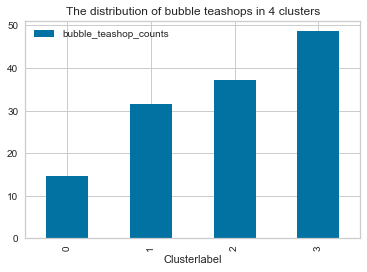

In [10]:
Groupbyfeaturecluster = Taipei_district_df.groupby(by="Clusterlabel").mean()
Groupbyfeaturecluster.reset_index().plot(kind="bar", x = "Clusterlabel", y =["bubble_teashop_counts"])
plt.title("The distribution of bubble teashops in 4 clusters")
plt.show()

### A plot the distribution of 5 features in the 4 clusters :

Text(0.5, 1.0, 'The distribution of features in 4 clusters')

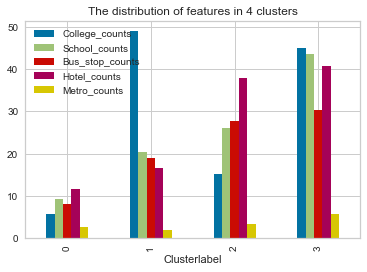

In [11]:
Groupbyfeaturecluster.reset_index().plot(kind="bar", x = "Clusterlabel", y =["College_counts", "School_counts", "Bus_stop_counts", "Hotel_counts", "Metro_counts"])
plt.title("The distribution of features in 4 clusters")

### Use the folium to show the 12 districts on Taipei City map with clustring labels :

In [12]:
Taipei_City = geolocator.geocode("Taipei City")
latitude = location.latitude
longitude = location.longitude


# set color scheme for the clusters
x = np.arange(kclusters_bubbletea)
ys = [i + x + (i*x)**2 for i in range(kclusters_bubbletea)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]



Taipei_district_map = folium.Map(location=[Taipei_City.latitude, Taipei_City.longitude], zoom_start=11)


# add markers to the map
markers_colors = []

for lat, lng, district, cluster in zip(Taipei_district_df.lat, Taipei_district_df.lng, Taipei_district_df.District, Taipei_district_df.Clusterlabel):
    label = folium.Popup(str(district) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=1000,
        color=rainbow[cluster-1],
        popup=label,
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.6
    ).add_to(Taipei_district_map
            )

    
Taipei_district_map

### Further clustering analysis using all kinds of venues found by Foursqure API

In [13]:
# Search for venues with high schools' locations

def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['name', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


### Create a dataframe for all venues found in the 12 districts using getNearbyVenues function :

In [14]:
Taipei_district_venue = getNearbyVenues(names = Taipei_district_df['District'],
                                   latitudes=Taipei_district_df['lat'],
                                   longitudes=Taipei_district_df['lng'])

print(Taipei_district_venue.shape)
Taipei_district_venue

Wanhua
Datong
Zhongzheng
Daan
Xinyi
Zhongshan
Songshan
Beitou
Shilin
Neihu
Nangang
Wenshan
(880, 7)


,name,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wanhua,25.031933,121.499332,Starbucks Coffee (星巴克（萬華林宅）),25.033512,121.498372,Coffee Shop
1,Wanhua,25.031933,121.499332,陳記專業腸蚵麵線,25.035152,121.498286,Taiwanese Restaurant
2,Wanhua,25.031933,121.499332,福州元祖胡椒餅,25.035485,121.500626,Snack Place
3,Wanhua,25.031933,121.499332,Longshan Temple (龍山寺),25.036956,121.499916,Buddhist Temple
4,Wanhua,25.031933,121.499332,大可居青年旅館 Duckstay Hostel,25.035768,121.503356,Hostel
...,...,...,...,...,...,...,...
875,Wenshan,24.989786,121.570458,公車貓纜動物園站,24.996290,121.576358,Bus Station
876,Wenshan,24.989786,121.570458,渣男 Taiwan Bistro《木柵二渣》,24.998257,121.570763,Sake Bar
877,Wenshan,24.989786,121.570458,公車捷運木柵站 MRT Muzha Sta. Bus Stop,24.997731,121.574055,Bus Station
878,Wenshan,24.989786,121.570458,里米特三明治,24.997818,121.574023,Sandwich Place


In [15]:
Taipei_district_venue.groupby('name').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
name,,,,,,
Beitou,57,57,57,57,57,57
Daan,100,100,100,100,100,100
Datong,100,100,100,100,100,100
Nangang,51,51,51,51,51,51
Neihu,30,30,30,30,30,30
Shilin,74,74,74,74,74,74
Songshan,60,60,60,60,60,60
Wanhua,67,67,67,67,67,67
Wenshan,41,41,41,41,41,41


#### Use one hot encoding for clustering analysis :

In [16]:
# one hot encoding 
Taipei_district_venue_onehot = pd.get_dummies(Taipei_district_venue[['Venue Category']], prefix="", prefix_sep="")

Taipei_district_venue_onehot['name'] = Taipei_district_venue['name']

Fixed_column = [Taipei_district_venue_onehot.columns[-1]] + list(Taipei_district_venue_onehot.columns[:-1])
Taipei_district_venue_onehot = Taipei_district_venue_onehot[Fixed_column]

Taipei_district_venue_onehot

Taipei_district_grouped = Taipei_district_venue_onehot.groupby('name').mean().reset_index()

Taipei_district_grouped

,name,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Tennis Stadium,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Xinjiang Restaurant
0,Beitou,0.00,0.00,0.00,0.017544,0.00,0.052632,0.000000,0.00,0.000000,...,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.017544,0.000000,0.00,0.00
1,Daan,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.030000,...,0.000000,0.000000,0.00,0.010000,0.00,0.000000,0.030000,0.000000,0.00,0.01
2,Datong,0.00,0.01,0.01,0.000000,0.00,0.040000,0.000000,0.01,0.010000,...,0.000000,0.010000,0.00,0.010000,0.00,0.000000,0.000000,0.000000,0.00,0.00
3,Nangang,0.00,0.00,0.00,0.000000,0.00,0.000000,0.019608,0.00,0.019608,...,0.000000,0.058824,0.00,0.019608,0.00,0.039216,0.000000,0.000000,0.00,0.00
4,Neihu,0.00,0.00,0.00,0.000000,0.00,0.100000,0.033333,0.00,0.000000,...,0.033333,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.033333,0.00,0.00
5,Shilin,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,...,0.000000,0.013514,0.00,0.000000,0.00,0.000000,0.000000,0.013514,0.00,0.00
6,Songshan,0.00,0.00,0.00,0.000000,0.00,0.066667,0.000000,0.00,0.000000,...,0.000000,0.000000,0.00,0.000000,0.00,0.016667,0.000000,0.000000,0.00,0.00
7,Wanhua,0.00,0.00,0.00,0.000000,0.00,0.014925,0.000000,0.00,0.029851,...,0.000000,0.000000,0.00,0.000000,0.00,0.014925,0.000000,0.000000,0.00,0.00
8,Wenshan,0.00,0.00,0.00,0.000000,0.00,0.024390,0.024390,0.00,0.000000,...,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00
9,Xinyi,0.01,0.00,0.00,0.000000,0.00,0.020000,0.010000,0.00,0.010000,...,0.000000,0.000000,0.00,0.020000,0.01,0.000000,0.030000,0.000000,0.00,0.00


### Show the top 5 venues for 12 districts :

In [17]:
num_top_venues = 5

for district in Taipei_district_grouped['name']:
    print("----"+district+"----")
    temp = Taipei_district_grouped[Taipei_district_grouped['name'] == district].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Beitou----
               venue  freq
0              Hotel  0.18
1  Convenience Store  0.09
2       Noodle House  0.07
3        Coffee Shop  0.07
4               Café  0.05


----Daan----
                           venue  freq
0                           Café  0.21
1                    Coffee Shop  0.07
2           Taiwanese Restaurant  0.07
3                       Tea Room  0.05
4  Vegetarian / Vegan Restaurant  0.03


----Datong----
                  venue  freq
0  Taiwanese Restaurant  0.12
1     Convenience Store  0.08
2          Dessert Shop  0.07
3                  Café  0.05
4      Asian Restaurant  0.04


----Nangang----
                  venue  freq
0           Coffee Shop  0.12
1     Convenience Store  0.08
2   Japanese Restaurant  0.08
3  Fast Food Restaurant  0.06
4       Thai Restaurant  0.06


----Neihu----
                  venue  freq
0     Convenience Store  0.17
1      Asian Restaurant  0.10
2           Coffee Shop  0.07
3  Taiwanese Restaurant  0.07
4     Korean 

## Cluster Analysis using the venues found with the 12 districts

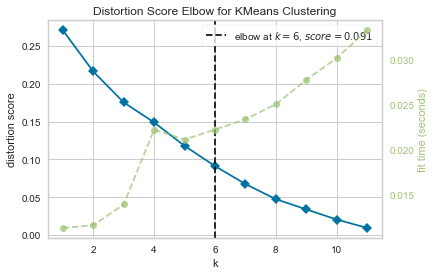

In [28]:
Taipei_district_clusering = Taipei_district_grouped.drop('name', 1)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(Taipei_district_clusering)
visualizer.show()

In [29]:
# set number of clusters
kclusters = 6

# run k-means clustering with number of cluster decided by elbow method
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Taipei_district_clusering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]



# create a new dataframe
District_venues_sorted = pd.DataFrame(columns = ['name'])
District_venues_sorted['name'] = Taipei_district_grouped['name']
District_venues_sorted.insert(0, 'Clusterlabel', kmeans.labels_)

Taipei_district_merge = Taipei_district_df.loc[:,['District', 'lat', 'lng']]
Taipei_district_merge.columns = ['name', 'latitude', 'longitude']
Taipei_district_merge.head()

Taipei_district_merge = Taipei_district_merge.join(District_venues_sorted.set_index('name'), on='name')
Taipei_district_merge.head()

,name,latitude,longitude,Clusterlabel
0,Wanhua,25.031933,121.499332,1
1,Datong,25.065986,121.515514,1
2,Zhongzheng,25.032361,121.518267,2
3,Daan,25.026515,121.534395,2
4,Xinyi,25.033345,121.566896,4


In [30]:
# create map
Taipei_City = geolocator.geocode("Taipei City")
latitude = location.latitude
longitude = location.longitude
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Taipei_district_merge['latitude'], Taipei_district_merge['longitude'], Taipei_district_merge['name'], Taipei_district_merge['Clusterlabel']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters